In [182]:
import os
import uuid
import hashlib
from urllib.parse import urlencode
import requests
from pprint import pprint
import jwt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output


In [ ]:
ACCESS_KEY = 'your access key'
SECRET_KEY = 'your secret key'
SERVER_URL = 'https://api.upbit.com'

In [153]:
def getAskPrice(coin):
    queryString = {"markets":"KRW-"+coin}
    headers = {"Accept": "application/json"}

    response = requests.request("GET", SERVER_URL+'/v1/orderbook', headers=headers, params=queryString)

    HTTP_OK = 200
    if response.status_code == HTTP_OK:
        #pprint(response.json())
        orderBookUnits = response.json()[0]['orderbook_units']
        askPrice = orderBookUnits[0]['ask_price']
        return float(askPrice)
    else :
        return -1

In [ ]:
price = getAskPrice('BTC')
print(price)

In [ ]:
def getCoinAmount(coin):
    payload = {
        'access_key': ACCESS_KEY,
        'nonce': str(uuid.uuid4()),
    }

    jwt_token = jwt.encode(payload, SECRET_KEY)
    authorize_token = 'Bearer {}'.format(jwt_token)
    headers = {"Authorization": authorize_token}

    res = requests.get(SERVER_URL + "/v1/accounts", headers=headers)
    
    for asset in res.json():
        if asset['currency'] == coin:
            return float(asset['balance'])

    return -1

In [ ]:
getCoinAmount('TRX')

In [ ]:
def bid(coin, price) :
    query = {
        'market': 'KRW-' + coin,
        'side': 'bid',  # buy
        #'volume': '0.01',
        'price': str(price),
        'ord_type': 'price', # buy
    }
    query_string = urlencode(query).encode()

    m = hashlib.sha512()
    m.update(query_string)
    query_hash = m.hexdigest()

    payload = {
        'access_key': ACCESS_KEY,
        'nonce': str(uuid.uuid4()),
        'query_hash': query_hash,
        'query_hash_alg': 'SHA512',
    }

    jwt_token = jwt.encode(payload, SECRET_KEY)
    authorize_token = 'Bearer {}'.format(jwt_token)
    headers = {"Authorization": authorize_token}

    res = requests.post(SERVER_URL+'/v1/orders', params=query, headers=headers)
    print(res)

In [ ]:
bid('ETH', 20000)

In [ ]:
def ask(coin, volume) :
    query = {
        'market': 'KRW-' + coin,
        'side': 'ask',  # sell
        'volume': str(volume),
        #'price': '100000',
        'ord_type': 'market', # sell
    }
    query_string = urlencode(query).encode()

    m = hashlib.sha512()
    m.update(query_string)
    query_hash = m.hexdigest()

    payload = {
        'access_key': ACCESS_KEY,
        'nonce': str(uuid.uuid4()),
        'query_hash': query_hash,
        'query_hash_alg': 'SHA512',
    }

    jwt_token = jwt.encode(payload, SECRET_KEY)
    authorize_token = 'Bearer {}'.format(jwt_token)
    headers = {"Authorization": authorize_token}
    
    res = requests.post(SERVER_URL+'/v1/orders', params=query, headers=headers)
    print(res)

In [ ]:
volume = getCoinAmount('ETH')
ask('ETH', volume)

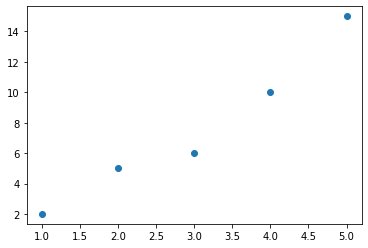

In [108]:
T = [[1],[2],[3],[4],[5]]
y = [2,5,6,10,15]

plt.scatter(T,y)
plt.show()

In [143]:
linReg = LinearRegression()
linReg.fit(T, y)

# y = wt + b
w = round(linReg.coef_[0],3)
b = round(linReg.intercept_,3)
print('w: ' + str(w))
print('b: ' + str(b))


w: 3.1
b: -1.7


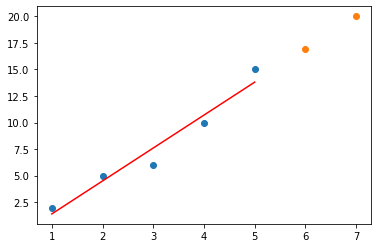

In [145]:
y_past = []
y_past.append( w * T[0][0] + b )
y_past.append( w * T[1][0] + b )
y_past.append( w * T[2][0] + b )
y_past.append( w * T[3][0] + b )
y_past.append( w * T[4][0] + b )

t_pred = [[6],[7]]
y_pred = []
y_pred.append( w * t_pred[0][0] + b )
y_pred.append( w * t_pred[1][0] + b )

plt.scatter(T,y)  # past
plt.plot(T,y_past, 'r')
plt.scatter(t_pred, y_pred) # predict
plt.show()

In [138]:
a = w * 6 + b
print('a: ' + str(a))

b = linReg.predict([[6]])
print('b: ' + str(b))

a: 16.900000000000002
b: [16.9]


In [ ]:
COIN = 'AXS'
INTERVAL_SEC = 3
y_SIZE = 60
T = [[i] for i in range(y_SIZE)]

y = []

linReg = LinearRegression()

while True:
    time.sleep(INTERVAL_SEC)
    
    price = getAskPrice(COIN)
    y.append(price)
    
    if len(y) < y_SIZE:
        print(y, end='\r', flush=True)
        continue
        
    linReg.fit(T, y)
    y_pred = linReg.predict([[y_SIZE]])
    
    # Add your logic !
    # ask() , bid()
    
    clear_output(wait=True)
    
    print('y_pred: ' + str(y_pred))
    print(y)
    plt.ylim(price*0.995, price*1.005)
    plt.scatter(T, y) # past
    plt.scatter(y_SIZE, y_pred) # predicted
    plt.show()
    
    y.pop(0)
